/root/sdrfly


SKIQ[168625]: <INFO> libsidekiq v4.18.1 (g58be05ffb)
python3[168625]: [card-0] <INFO> Sidekiq card is serial number=7G2Y, hardware M2 C (rev C), product SKIQ-M2-002 (M.2) (part ES01420*-C0-00)
python3[168625]: [card-0] <INFO> Firmware v2.9
python3[168625]: [card-0] <INFO> Sidekiq: FPGA v3.18.1, (date 24052819, FIFO size 16k)
python3[168625]: [card-0] <INFO> Sidekiq card is configured for an internal reference clock
python3[168625]: [card-0] <INFO> Loading calibration data for Sidekiq M.2
python3[168625]: [card-0] <INFO> RF IC version 5.5.1
python3[168625]: [card-0] <INFO> Number of tx channels supported 1, number of rx channels supported 1
python3[168625]: [card-0] <INFO> Default warp voltage not currently stored (user)
[INFO] Using format CF32.
[INFO] Starting RX Sidekiq Thread
/tmp/ipykernel_168625/1295786882.py:19: RuntimeWarning: divide by zero encountered in log10
  fft_magnitude_db = 20 * np.log10(fft_magnitude)


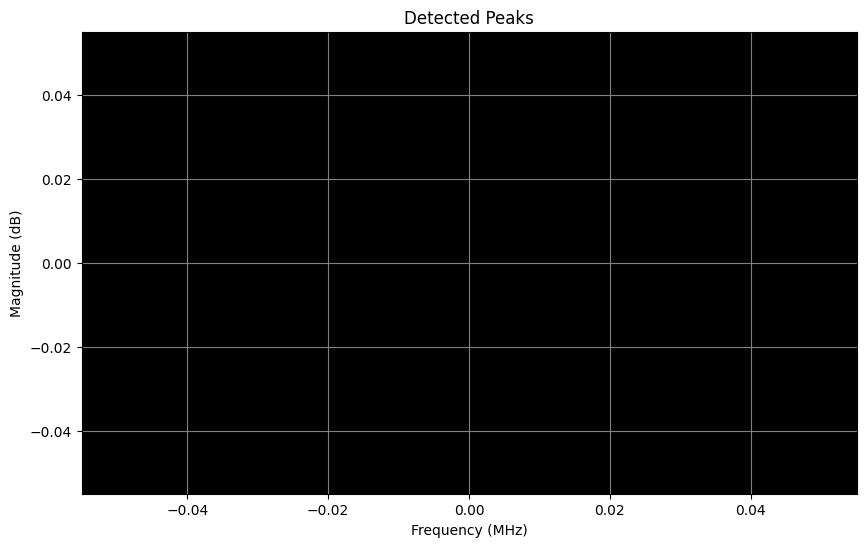

: 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sdr_plot_backend.signal_utils import detect_signal_peaks_freq_power
from sdrfly.sdr.sdr_generic import SDRGeneric
import time

def sweep_and_detect_peaks(start_freq, stop_freq, sample_rate, bandwidth, sdr_type="sidekiq"):
    fft_size = 1024
    sdr = SDRGeneric(sdr_type, center_freq=start_freq, sample_rate=sample_rate, bandwidth=bandwidth, gain=30, size=fft_size)
    sdr.start()

    full_fft = np.zeros(fft_size)
    current_freq = start_freq

    while current_freq <= stop_freq:
        iq_data = sdr.get_latest_samples()
        fft_result = np.fft.fftshift(np.fft.fft(iq_data, fft_size))
        fft_magnitude = np.abs(fft_result)
        fft_magnitude_db = 20 * np.log10(fft_magnitude)
        full_fft += fft_magnitude_db

        current_freq += bandwidth
        sdr.set_frequency(current_freq)
    
    sdr.stop()
    
    averaged_fft_db = full_fft / ((stop_freq - start_freq) / bandwidth + 1)
    signal_peaks = detect_signal_peaks_freq_power(averaged_fft_db, (start_freq + stop_freq) / 2, sample_rate, fft_size)

    # Plot the results in dark mode
    frequencies = np.linspace(start_freq, stop_freq, fft_size)

    plt.figure(figsize=(10, 6))
    plt.plot(frequencies / 1e6, averaged_fft_db, color='yellow')
    for freq, power in signal_peaks:
        plt.axvline(freq, color='red', linestyle='--')
        plt.text(freq, power, f'{freq:.2f} MHz\n{power:.2f} dB', color='white')
    plt.title("Detected Peaks")
    plt.xlabel("Frequency (MHz)")
    plt.ylabel("Magnitude (dB)")
    plt.grid(True, color='gray')
    plt.gca().set_facecolor('black')
    plt.show()

    # Print out the detected peaks and their power levels
    print("Detected peaks:")
    for freq, power in signal_peaks:
        print(f"Frequency: {freq:.2f} MHz, Power: {power:.2f} dB")

# Sweep settings
start_freq = 80e6  # Start frequency in Hz
stop_freq = 150e6  # Stop frequency in Hz
sample_rate = 60e6  # Sample rate in Hz
bandwidth = 60e6  # Bandwidth in Hz

# Perform the sweep and detect peaks
sweep_and_detect_peaks(start_freq, stop_freq, sample_rate, bandwidth)
